In [1]:
from blop.utils import prepare_re_env

%run -i C:\\Users\\megha\\src\\blop\\src\\blop\\utils\\prepare_re_env.py --db-type=temp

bec.disable_plots()

In [2]:
from blop.sim import Beamline

bl = Beamline(name="bl")

In [3]:
import gpytorch
import torch
import blop
import numpy as np

In [4]:
import bluesky.plans as bp

# RE(bp.scan([bl.det], bl.kbv_usv, -2, 2, 11))

In [5]:
def process_beam(image): 

    image = image - image.min()
    
    flux = image.sum()
    im2 = image
    # Perform SVD
    U, S, Vt = np.linalg.svd(image)

    # Reconstruct the image using the first few singular values
    k = 1  # Number of singular values to use
    reconstructed = np.dot(U[:, :k], np.dot(np.diag(S[:k]), Vt[:k, :]))
    
    column_sums = np.sum(reconstructed, axis = 0)
    row_sums = np.sum(reconstructed, axis = 1)
    
    height_threshold = np.mean(row_sums) + 0.75 * np.std(row_sums)
    
    # Find the indices where the row sums cross the threshold
    above_threshold_h = np.where(row_sums > height_threshold)[0]
    if len(above_threshold_h) > 1:
        start_index_h = above_threshold_h[0]
        end_index_h = above_threshold_h[-1]
        height = end_index_h-start_index_h
        im2 = im2[start_index_h: end_index_h]
        ypos = (end_index_h+start_index_h)/2
    else: 
        height = 1
        ypos = 0
    
    width_threshold = np.mean(column_sums) + 0.75 * np.std(column_sums)
    above_threshold_w = np.where(column_sums > width_threshold)[0]
    # Find the indices where the column sums cross the threshold
    if len(above_threshold_w) > 1:
        start_index_w = above_threshold_w[0]
        end_index_w = above_threshold_w[-1]
        width = end_index_w-start_index_w
        im2 = im2 [:, start_index_w: end_index_w]
        xpos = (end_index_w+start_index_w)/2
    else: 
        width = 1
        xpos = 0

    flux = im2.sum() if im2.sum() > 0 else 1
    #return width, height, flux
    return width, height, flux, xpos, ypos
    #return np.log(width), np.log(height), np.log(flux)

In [6]:
from blop import DOF, Objective, Agent


def digestion(df,  image_key="bl_det_image", **kwargs):
   
    for index, entry in df.iterrows():

        image = entry.loc[image_key]

        w, h, f, x, y = process_beam(image)

        df.loc[index, "flux"] = f
        df.loc[index, "width"] = w
        df.loc[index, "height"] = h
        df.loc[index, "x_pos"] = x
        df.loc[index, "y_pos"] = y
        
    return df


dofs = [DOF(device=bl.kbv_usv, search_domain=(-7, 7)), 
      DOF(device=bl.kbv_dsv, search_domain=(-7, 7)), 
      DOF(device=bl.kbh_ush, search_domain=(-7, 7)), 
      DOF(device=bl.kbh_dsh, search_domain=(-7, 7))]

objectives = [
    Objective(name="width", transform="log", trust_domain=(1, 300), target="min", latent_groups=[("bl_kbh_ush", "bl_kbh_dsh")]),
    Objective(name="height", transform="log", trust_domain=(1, 250), target="min", latent_groups=[("bl_kbv_usv", "bl_kbv_dsv")]),
    Objective(name="flux", transform="log"), #, trust_domain=(200, np.inf)),
    Objective(name="x_pos", weight=0),
    Objective(name="y_pos", weight=0),
]

agent = Agent(dofs=dofs, 
              objectives=objectives, 
              detectors=[bl.det],
              digestion=digestion,
              enforce_all_objectives_valid=True,
              verbose=True,
              db=db)

In [7]:
RE(agent.learn("qr", n=16))

running iteration 1 / 1


Transient Scan ID: 1     Time: 2024-08-01 12:05:18
Persistent Unique Scan ID: '00f9b872-e875-44c2-ac22-31ede4bc8e46'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+
|   seq_num |       time | bl_kbv_usv | bl_kbv_dsv | bl_kbh_ush | bl_kbh_dsh | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |
+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+
|         1 | 12:05:18.3 |     -1.820 |      1.421 |      3.241 |      2.197 |    435.454 |      221.091 |      101.318 |      115.798 |       45.629 |
|         2 | 12:05:18.5 |     -4.993 |      1.882 |      5.532 |     -0.326 |     44.483 |      274.688 |       89.015 |       43.557 |       26.966 |
|         3 | 12:05:18.7 |     -5.846 |     -4.450 |      1.654 |     -2.94

('00f9b872-e875-44c2-ac22-31ede4bc8e46',)

In [9]:
for i in range(4):
    print(i)
    agent.prune(pruning_objs = [agent.objectives.width, agent.objectives.height, agent.objectives.x_pos, agent.objectives.y_pos], thresholds = [1, 1, 1, 1])
    RE(agent.learn("qei", n=2, iterations=1))

0


C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


trained models in 13.1 seconds
running iteration 1 / 1


Transient Scan ID: 2     Time: 2024-08-01 12:06:34
Persistent Unique Scan ID: 'b9356b00-db38-460d-95dd-c26e2f359224'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+
|   seq_num |       time | bl_kbv_usv | bl_kbv_dsv | bl_kbh_ush | bl_kbh_dsh | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |
+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+
|         1 | 12:06:34.2 |      4.196 |      2.147 |     -0.521 |     -1.361 |    431.565 |      214.483 |      178.007 |       74.624 |       78.837 |
|         2 | 12:06:34.4 |      7.000 |     -3.547 |     -1.528 |     -1.652 |     -4.025 |      202.496 |      157.477 |      357.246 |      257.860 |
+-----------+------------+------------+-----

C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


trained model 'y_pos' in 2625 ms
1


C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


trained models in 12.0 seconds
running iteration 1 / 1


Transient Scan ID: 3     Time: 2024-08-01 12:07:01
Persistent Unique Scan ID: '484cc927-a457-4a5d-822a-0d0079eb3230'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+
|   seq_num |       time | bl_kbv_usv | bl_kbv_dsv | bl_kbh_ush | bl_kbh_dsh | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |
+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+
|         1 | 12:07:02.0 |      0.942 |      0.211 |     -0.362 |     -0.614 |    542.005 |      204.139 |      159.976 |       54.644 |       19.001 |
|         2 | 12:07:02.2 |     -5.442 |      2.607 |      0.774 |     -0.002 |     46.555 |      214.500 |       82.250 |       16.554 |       14.747 |
+-----------+------------+------------+-----

C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


trained models in 16.5 seconds
running iteration 1 / 1


Transient Scan ID: 4     Time: 2024-08-01 12:07:32
Persistent Unique Scan ID: '3791d13a-b92e-4df4-91ee-b3bc13ee8d06'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+
|   seq_num |       time | bl_kbv_usv | bl_kbv_dsv | bl_kbh_ush | bl_kbh_dsh | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |
+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+
|         1 | 12:07:32.7 |     -1.347 |      0.705 |      0.443 |     -0.437 |    536.242 |      216.520 |      118.396 |       31.223 |       52.746 |
|         2 | 12:07:32.9 |     -1.576 |      0.564 |      3.067 |      1.265 |    456.328 |      234.784 |      116.188 |       88.034 |       58.959 |
+-----------+------------+------------+-----

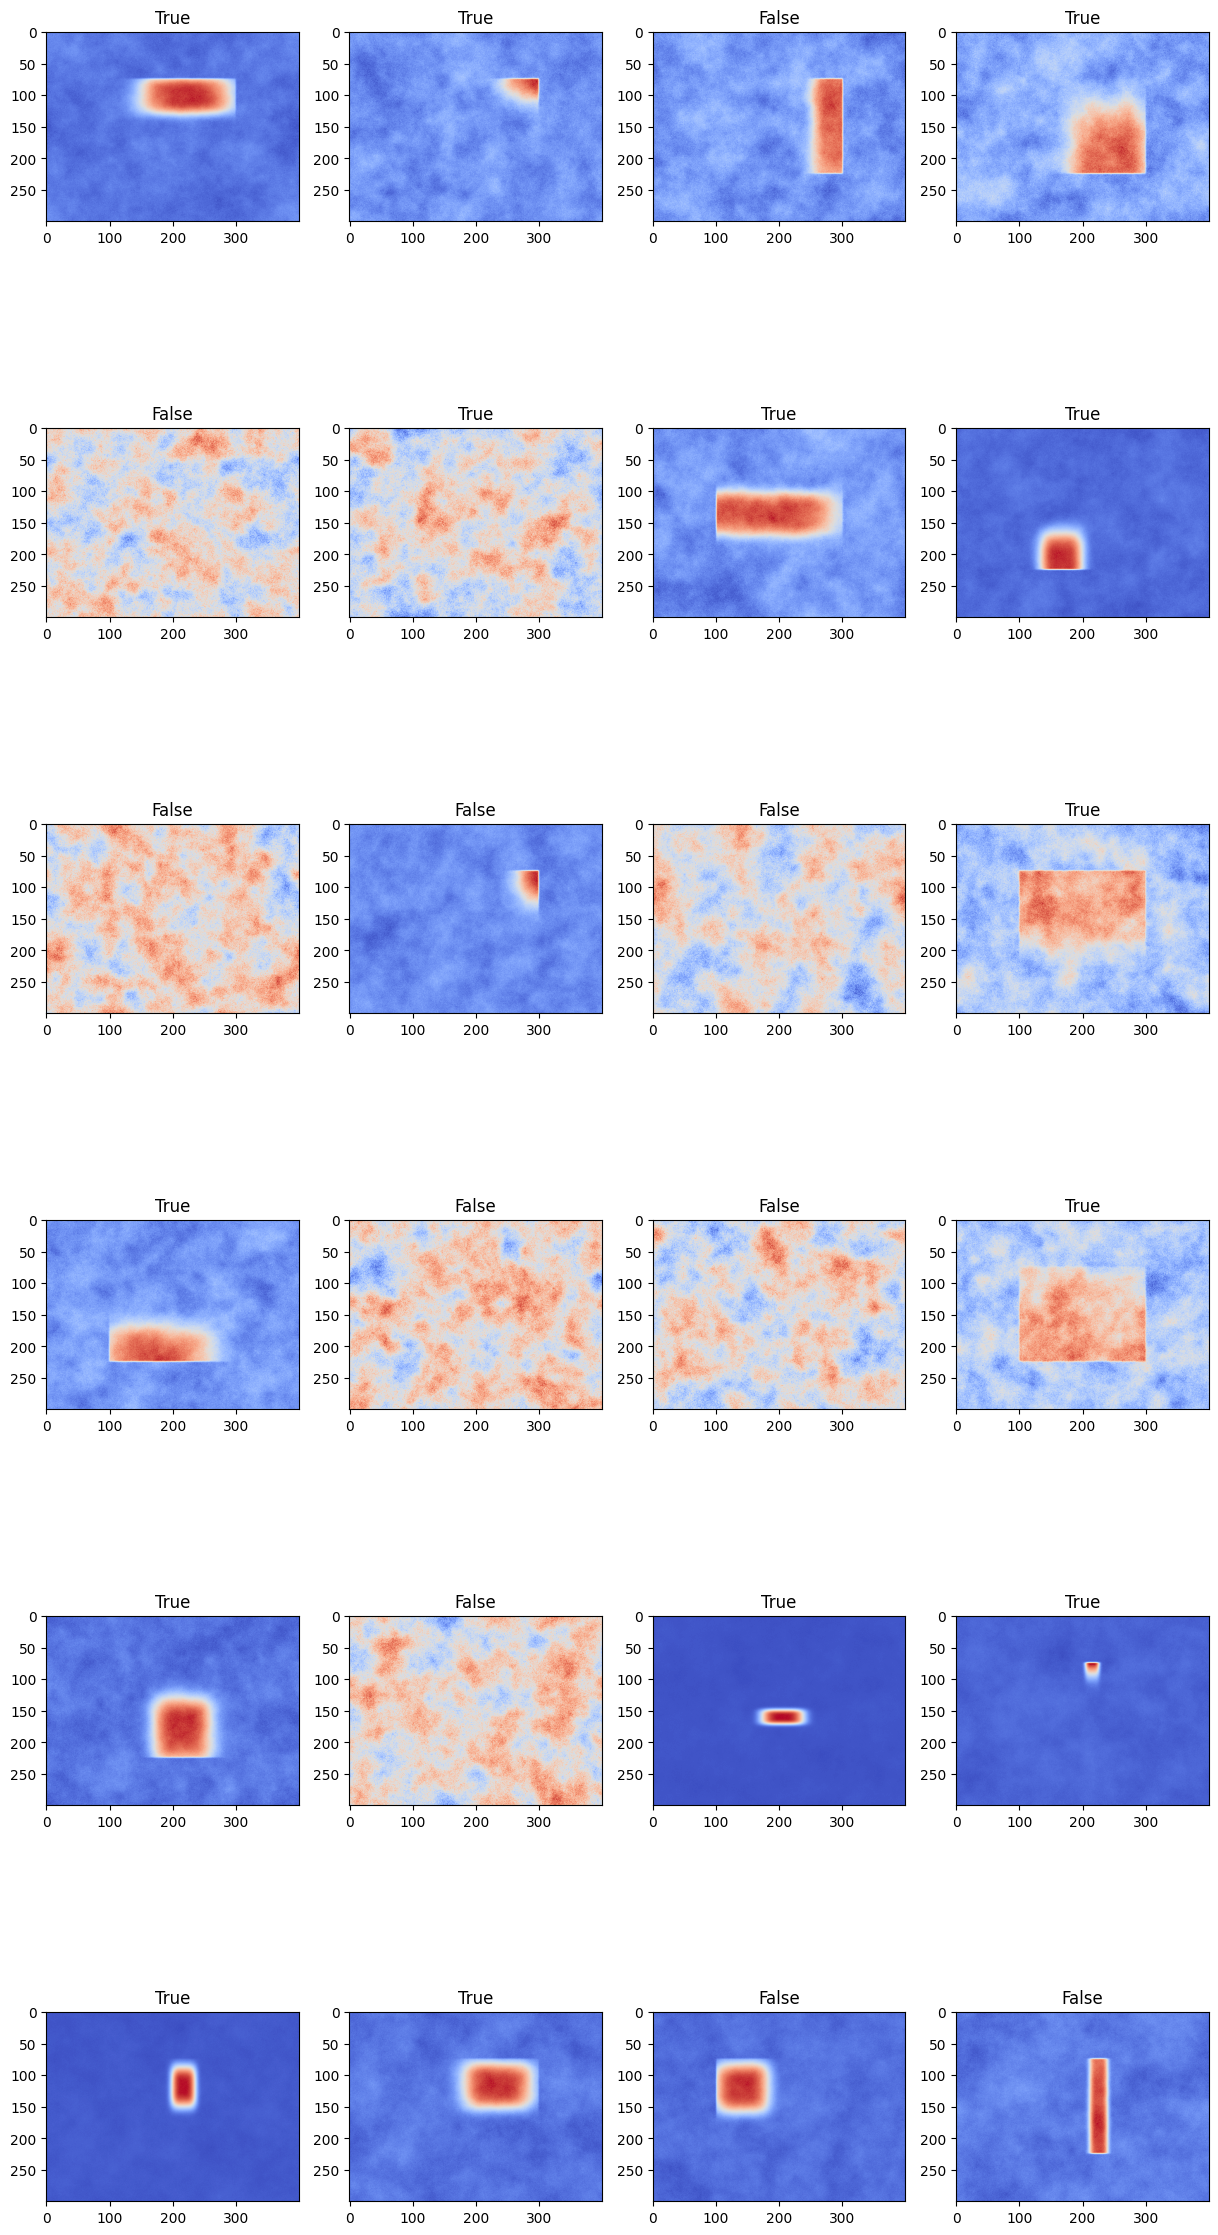

In [10]:
is_bad_point = (torch.isnan(agent.train_targets()["width"]) 
| torch.isnan(agent.train_targets()["height"])
| torch.isnan(agent.train_targets()["flux"]))

f, axarr = plt.subplots(6,4, figsize=(15, 30))
for i in range(6):
    for j in range(4):
        axarr[i][j].imshow(agent.table.bl_det_image[i*4+j])
        axarr[i][j].set_title(not (agent.table.prune[i*4+j] or is_bad_point[i*4+j].item()))

In [11]:
#agent.prune(pruning_objs = [agent.objectives.width, agent.objectives.height, agent.objectives.x_pos, agent.objectives.y_pos], thresholds = [1.0, 1.0, 1.0, 1.0])
agent.pruned_mask()

tensor([False, False,  True, False, False, False, False, False,  True,  True,
        False, False, False,  True, False, False, False,  True, False, False,
        False, False, False, False])

In [12]:
agent.table

,bl_kbv_usv,bl_kbv_dsv,bl_kbh_ush,bl_kbh_dsh,width,height,flux,x_pos,y_pos,time,...,bl_det_area,bl_det_cen_x,bl_det_cen_y,bl_det_wid_x,bl_det_wid_y,bl_det_image,bl_det_image_shape,bl_det_noise,acqf,prune
0,-1.819690,1.420716,3.241259,2.196542,121.0,54.0,443.586330,220.5,103.0,2024-08-01 16:05:18.310577631,...,0.0,221.090909,101.318361,115.797727,45.628964,"[[0.004635190578353627, 0.00490826412349573, 0...","[300, 400]",True,quasi-random,False
1,-4.993053,1.882236,5.531935,-0.325510,142.0,36.0,93.476635,229.0,92.0,2024-08-01 16:05:18.517103434,...,0.0,274.687752,89.015220,43.556754,26.965856,"[[0.0007013773606571578, 0.0012680278149654859...","[300, 400]",True,quasi-random,False
2,-5.845648,-4.449620,1.653890,-2.948009,51.0,136.0,224.511223,273.5,144.0,2024-08-01 16:05:18.732668400,...,0.0,277.967963,146.687057,37.068935,127.293627,"[[-0.0020924304415111707, -0.00274970544167249...","[300, 400]",True,quasi-random,True
3,-0.926133,-5.840635,3.519883,1.323098,111.0,88.0,262.287173,240.5,180.0,2024-08-01 16:05:19.027261972,...,0.0,244.279331,175.568327,89.346467,86.027831,"[[-0.001102905438594152, -0.000156898788542481...","[300, 400]",True,quasi-random,False
4,-3.079579,-2.498822,-2.324864,6.567944,261.0,299.0,643.750100,144.5,149.5,2024-08-01 16:05:19.244419098,...,0.0,183.540451,152.610764,285.574653,266.107639,"[[0.0008525685545467414, 0.0010635587878889269...","[300, 400]",True,quasi-random,False
5,-0.541444,5.169489,-4.462768,3.938078,279.0,87.0,221.793990,181.5,150.5,2024-08-01 16:05:19.406777620,...,0.0,176.128571,115.525962,336.142857,196.701923,"[[-0.0019695808140855974, -0.00333840450264621...","[300, 400]",True,quasi-random,False
6,1.981030,2.867049,-4.020069,-2.399542,164.0,65.0,432.324759,183.0,136.5,2024-08-01 16:05:19.556958914,...,0.0,183.725213,135.990486,150.008759,54.626667,"[[-0.0023101273130049305, -0.00083267908975676...","[300, 400]",True,quasi-random,False
7,5.151405,0.874259,-1.305998,0.340309,67.0,57.0,311.884118,166.5,195.5,2024-08-01 16:05:19.716208696,...,0.0,166.010870,196.298878,55.019565,49.465147,"[[-0.0029365833274990726, -0.00276662732706227...","[300, 400]",True,quasi-random,False
8,3.346342,-0.008295,4.827304,-6.771785,234.0,203.0,458.377629,208.0,164.5,2024-08-01 16:05:19.977606058,...,0.0,199.479651,146.268065,391.095414,265.066900,"[[-0.0016929773233795044, -0.00283832421212812...","[300, 400]",True,quasi-random,True
9,0.689112,6.292612,1.933838,-4.144393,43.0,56.0,78.694500,277.5,103.0,2024-08-01 16:05:20.276648283,...,0.0,285.126698,95.785977,24.709395,38.654713,"[[0.0024269030554062883, 0.0018762638567925791...","[300, 400]",True,quasi-random,True


In [13]:
mll = gpytorch.mlls.ExactMarginalLogLikelihood(agent.objectives.width.model.likelihood, agent.objectives.width.model)

In [26]:
mlls = mll(agent.objectives.width.model(agent.train_inputs()), agent.train_targets()["width"].unsqueeze(-1)).detach()
mlls -= np.nanmax(mlls)

In [27]:
mlls

tensor([-32.1355,      nan, -49.1458,  -7.1794, -86.4549,      nan, -83.8847,
        -60.8126, -81.9414, -70.2705,  -8.0902, -50.3716,   0.0000, -52.1477,
        -16.0863, -86.0356, -18.8430, -36.5687,  -4.2904, -15.3631, -20.7827,
        -15.3631, -10.6859,  -4.2904], dtype=torch.float64)